In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

In [2]:

# df_TagDesc = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv')

# df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_1o2.csv')
# df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_2o2.csv')
# # Concatenate (union) the dataframes
# df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

df_All = pd.read_csv(r'C:\Users\austinsh\Project-OptiC4\III Models\3 Model C10\3 Feature Selection\filtered-out_5-9_corr.csv')

print(df_All.head())


                  Date  425_pct_Al     Al2O3  M_Value  C4_pct_Eth  C4_pct_H2O  \
0  2012-05-17 09:00:00    6.319560  11.41670  3.50773    2.554580     22.0531   
1  2012-05-17 10:00:00    6.319915  11.40835  3.50797    2.555935     22.0557   
2  2012-05-17 12:00:00    6.320970  11.39165  3.50869    2.560005     22.0636   
3  2012-05-18 08:00:00    6.328690  11.39165  3.51401    2.540370     22.0604   
4  2012-05-18 09:00:00    6.336060  11.40500  3.51910    2.514430     22.0484   

   HydWtr_pct_Ammonia  C4_pct_Hex  HydWtr_Na2O  Decanol  ...   LC55557  \
0            0.867508    0.670721     3.354160  1.03026  ...  66.31395   
1            0.864729    0.671059     3.306475  1.03026  ...  66.31395   
2            0.856391    0.672071     3.163420  1.06326  ...  66.31395   
3            0.811652    0.674174     2.238130  1.51850  ...  65.92560   
4            0.773793    0.675408     1.391475  1.51850  ...  65.92560   

    LC55568    LC90366   LC90368   PI55004   PI55020   TC55552   TC5

### Include

In [3]:
# selected_columns = ['Butanol', 
#                     'FC55569',
#                     'DI55152',
#                     '425 %Al',
#                     'TC55552',
#                     'FC55003',
#                     'LC55555',
#                     'FFC55553',
#                     'FFC55555',
#                     'TC55555',
#                     'TI55021',
#                     'PI55004',
#                     'FC55552'
#                     ]
# existing_columns = [col for col in selected_columns if col in df_All.columns]
# df_All = df_All[existing_columns]

# print(df_All.head())

In [4]:
# Set max columns to display
pd.set_option('display.max_columns', None)

### Exlcude

In [5]:
# # List of columns to exclude to run XGboost feature selection
exclude_columns = [
                'Date',
                
                # Round 1
                'TI40050',
                'TC55555',
                'LC55568',
                'LC55557',
                'Al2O3',
                'LC55553',

                # Round 2
                'FC55576',
                'PI55004',

                # Round 3 - Excluding this one because OLS and FSF agree, but it wasn't captured by XGB-FS
                'DI55580',

                #Round 4 - Round 3 dropped another in XGB-FS
                'LC52572'
                
                # 'M_Value',
                # 'FFC55553',
                # 'DI55580',
                # 'Al2O3',
                # 'C4_pct_Hex',
                # 'LC52572'

                   ]

# # Create a new DataFrame without the excluded columnsd
df_All = df_All.drop(columns=exclude_columns)

print(df_All.head())

   425_pct_Al  M_Value  C4_pct_Eth  C4_pct_H2O  HydWtr_pct_Ammonia  \
0    6.319560  3.50773    2.554580     22.0531            0.867508   
1    6.319915  3.50797    2.555935     22.0557            0.864729   
2    6.320970  3.50869    2.560005     22.0636            0.856391   
3    6.328690  3.51401    2.540370     22.0604            0.811652   
4    6.336060  3.51910    2.514430     22.0484            0.773793   

   C4_pct_Hex  HydWtr_Na2O  Decanol   DI55102   DI55152   FC55003    FC55009  \
0    0.670721     3.354160  1.03026  0.965043  0.924515  5308.885  1182.3935   
1    0.671059     3.306475  1.03026  0.965043  0.924515  5308.885  1182.3935   
2    0.672071     3.163420  1.06326  0.965043  0.924515  5308.885  1182.3935   
3    0.674174     2.238130  1.51850  0.971625  0.933431  5297.320   966.1866   
4    0.675408     1.391475  1.51850  0.971625  0.933431  5297.320   966.1866   

    FC55552   FC55569  FFC55553  FFC55555    LC90366   LC90368   PI55020  \
0  40409.25  6924.645 

In [6]:
df_All.columns

Index(['425_pct_Al', 'M_Value', 'C4_pct_Eth', 'C4_pct_H2O',
       'HydWtr_pct_Ammonia', 'C4_pct_Hex', 'HydWtr_Na2O', 'Decanol', 'DI55102',
       'DI55152', 'FC55003', 'FC55009', 'FC55552', 'FC55569', 'FFC55553',
       'FFC55555', 'LC90366', 'LC90368', 'PI55020', 'TC55552', 'TI55021'],
      dtype='object')

In [7]:
# df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [8]:
# df_All.drop('Date', axis=1, inplace=True)

In [9]:
print(df_All.describe())

         425_pct_Al       M_Value    C4_pct_Eth    C4_pct_H2O  \
count  40127.000000  40127.000000  40127.000000  40127.000000   
mean       6.133716      3.597077      1.213887     21.178645   
std        0.228800      0.179868      0.691779      2.750323   
min        5.270185      1.255950      0.030786      7.714985   
25%        6.003510      3.502715      0.621701     18.843125   
50%        6.135865      3.588030      1.103350     21.462900   
75%        6.265830      3.682920      1.687807     23.275925   
max        7.026215      5.827565      9.466675     34.151950   

       HydWtr_pct_Ammonia    C4_pct_Hex   HydWtr_Na2O       Decanol  \
count        40127.000000  40127.000000  40127.000000  40127.000000   
mean             0.967938      0.471411      0.789919      3.118667   
std              0.146452      0.241196      0.686560      1.500695   
min              0.374388      0.000327      0.002854      0.172500   
25%              0.877260      0.353947      0.450232      

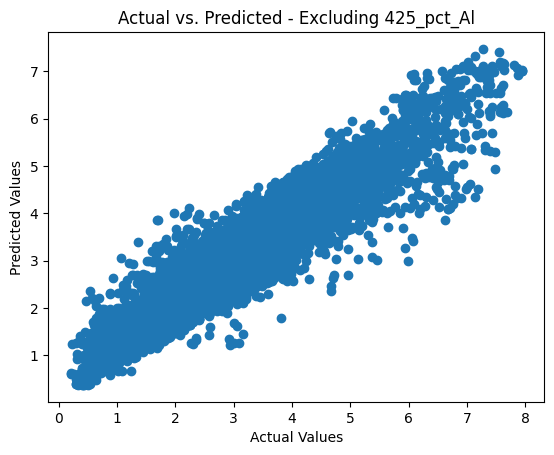

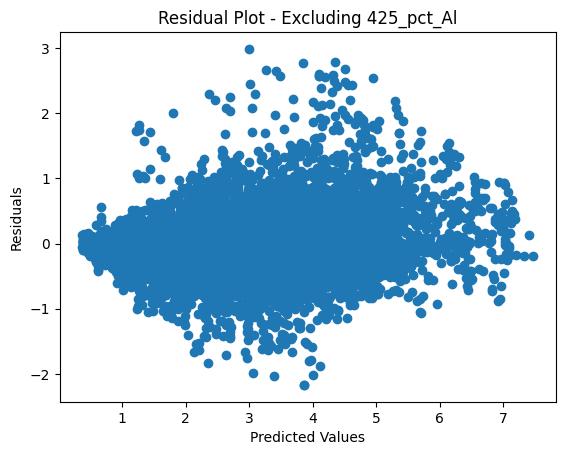

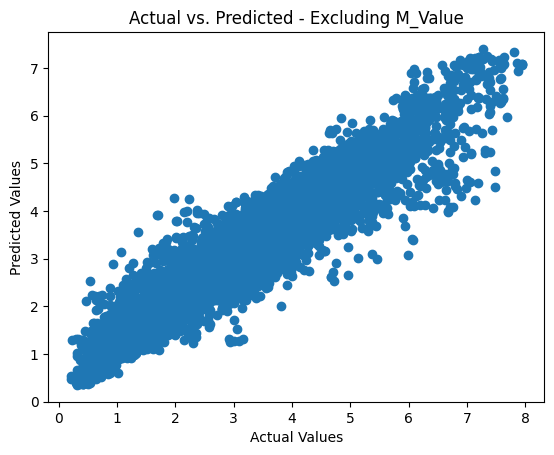

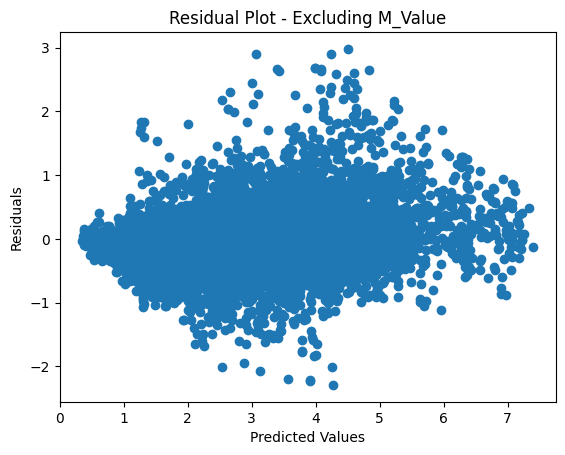

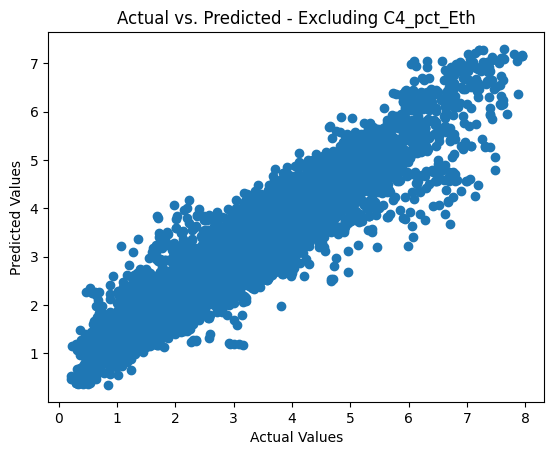

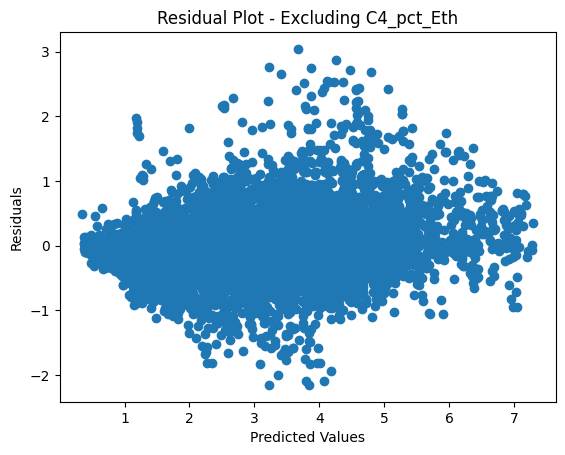

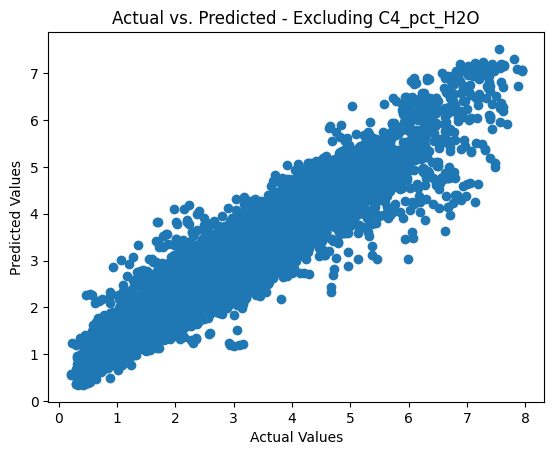

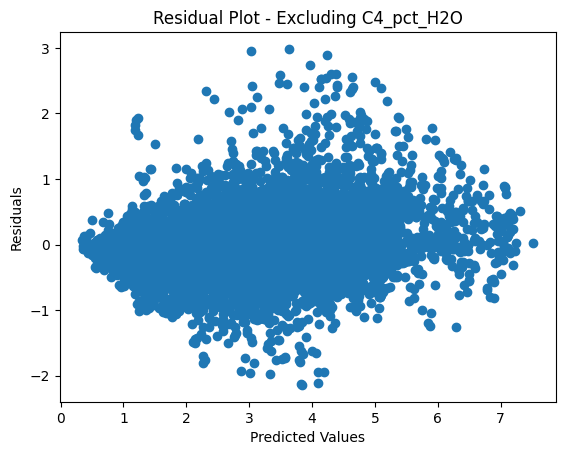

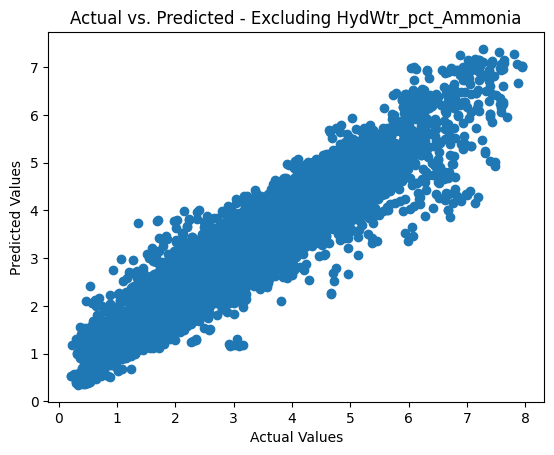

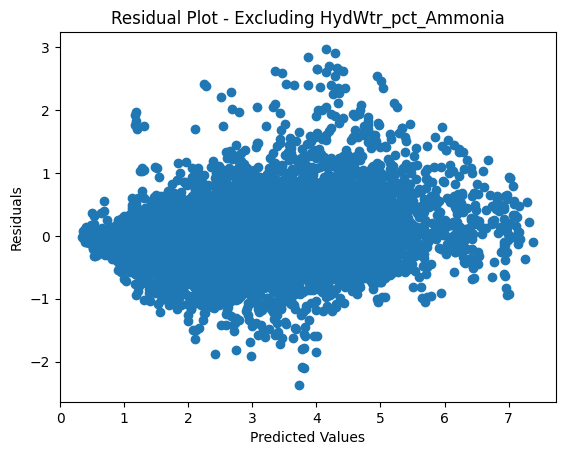

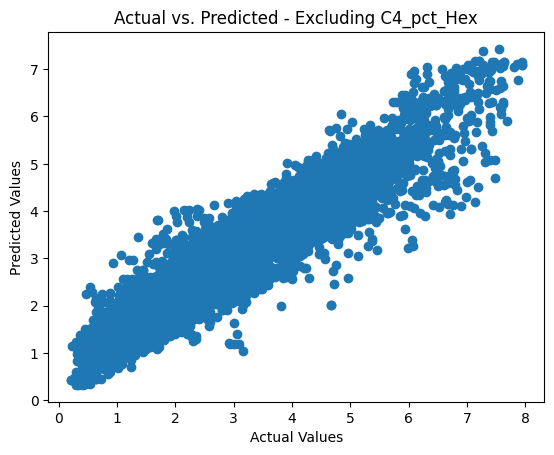

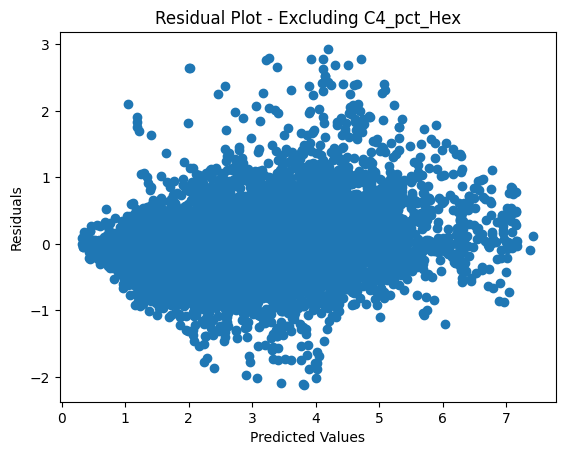

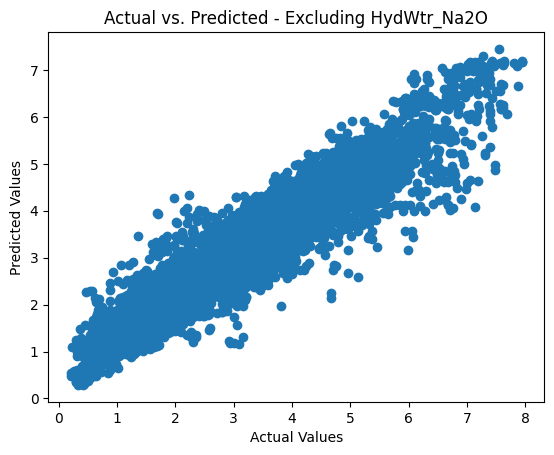

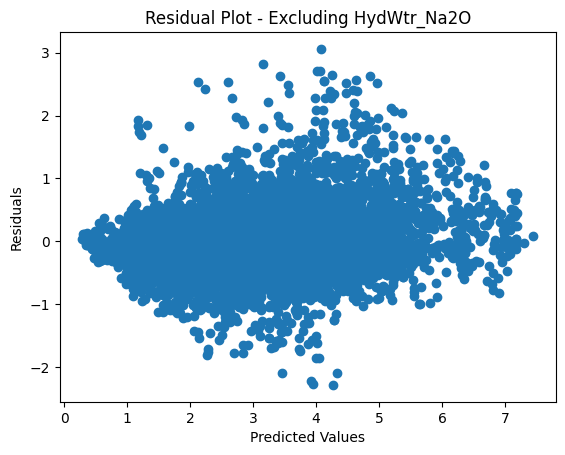

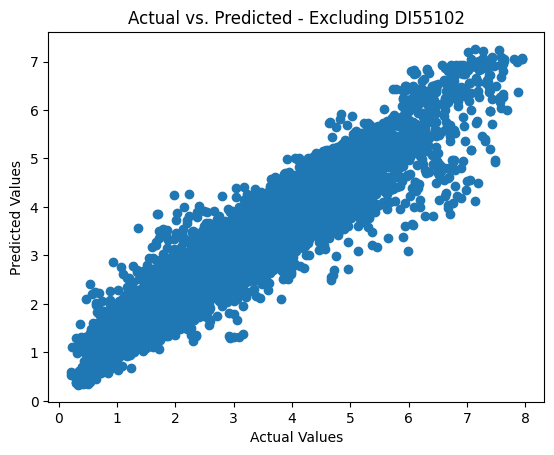

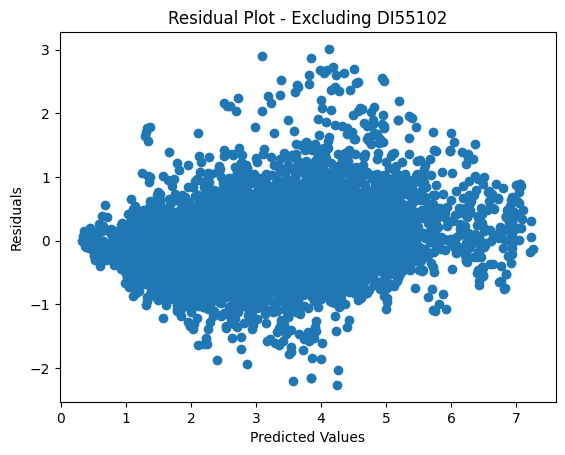

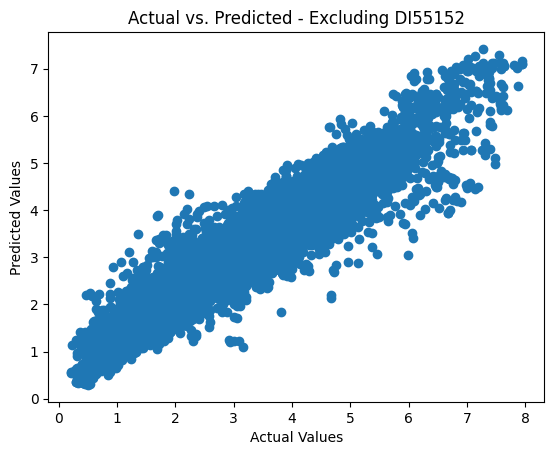

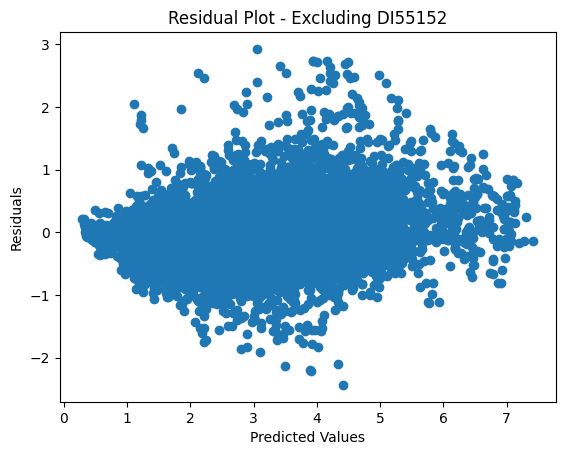

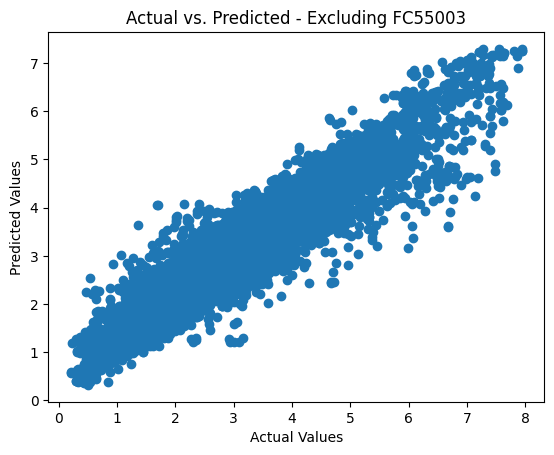

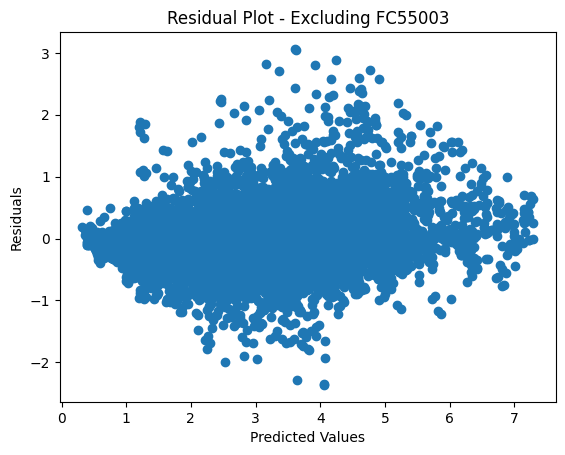

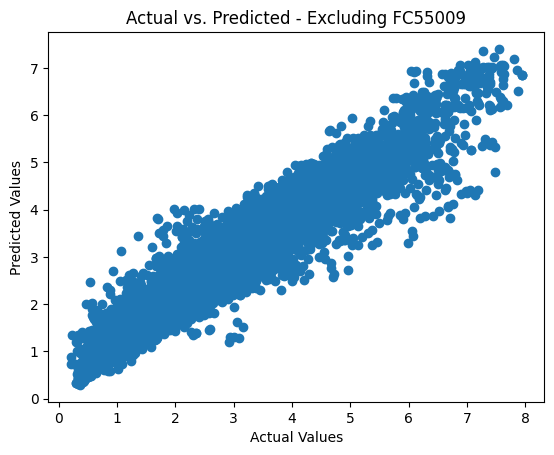

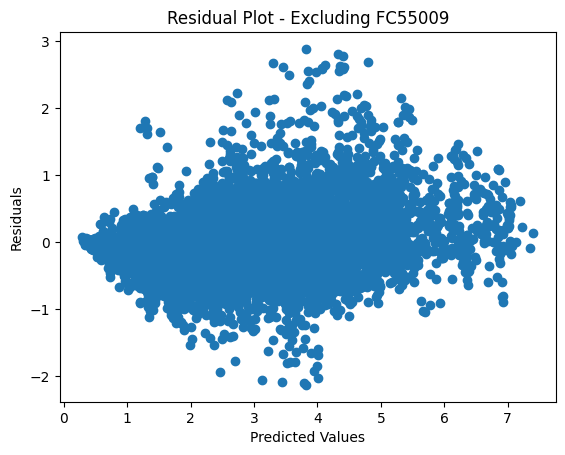

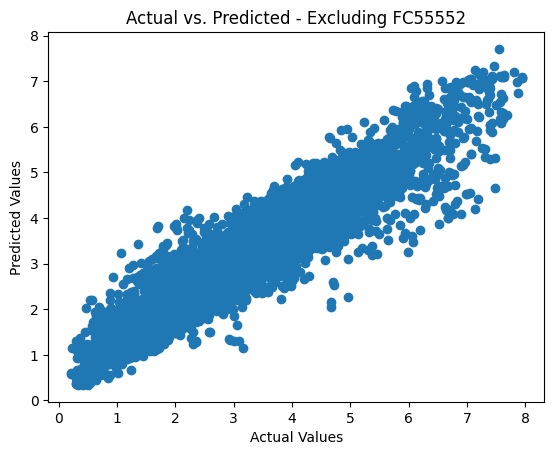

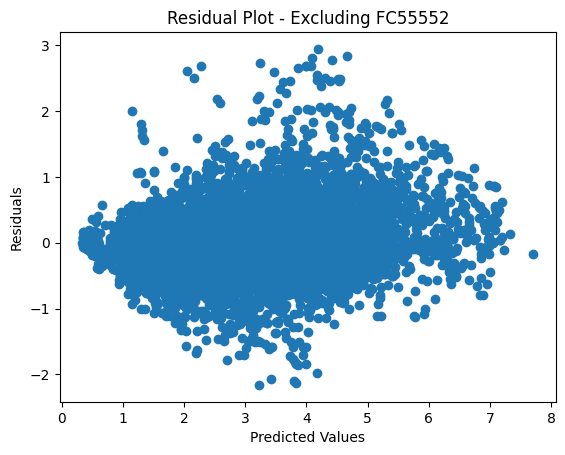

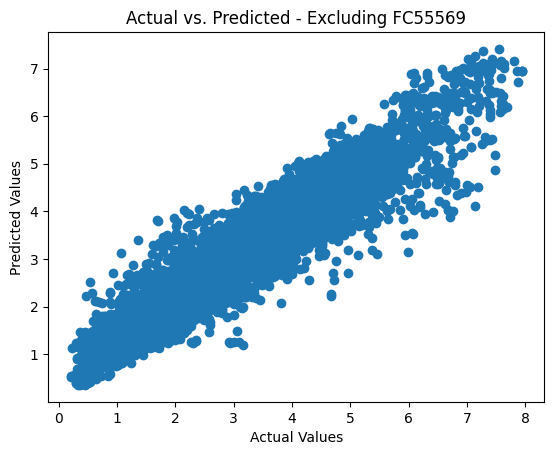

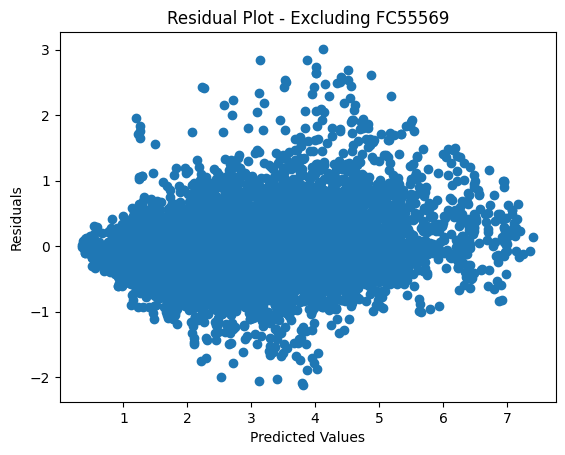

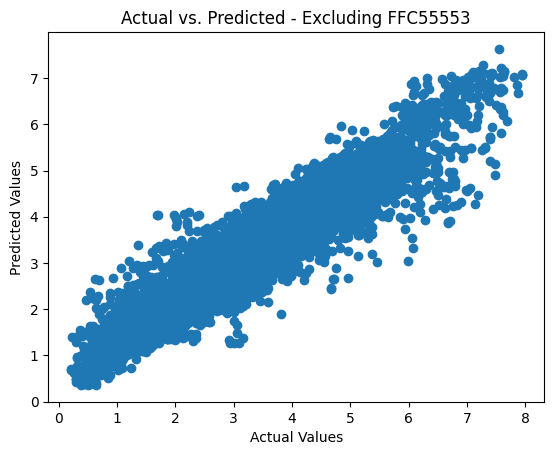

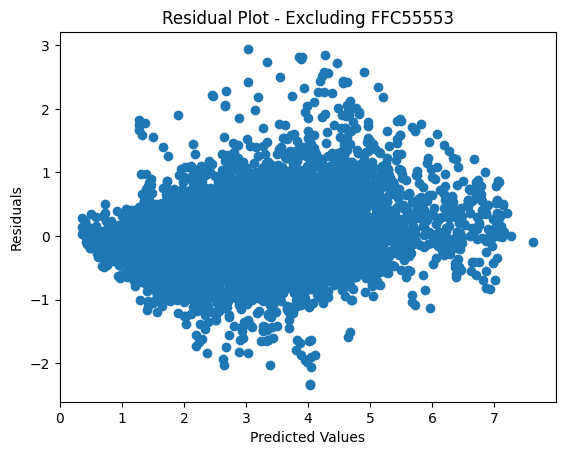

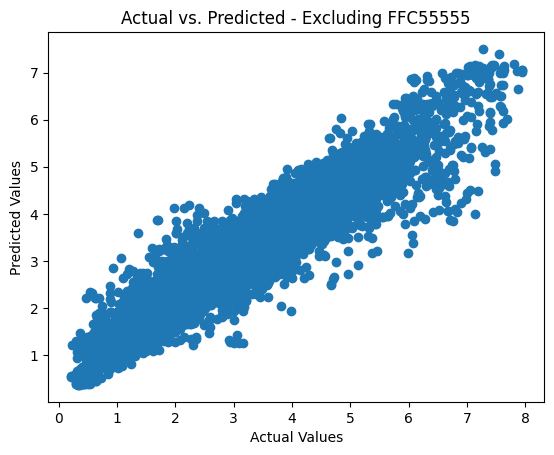

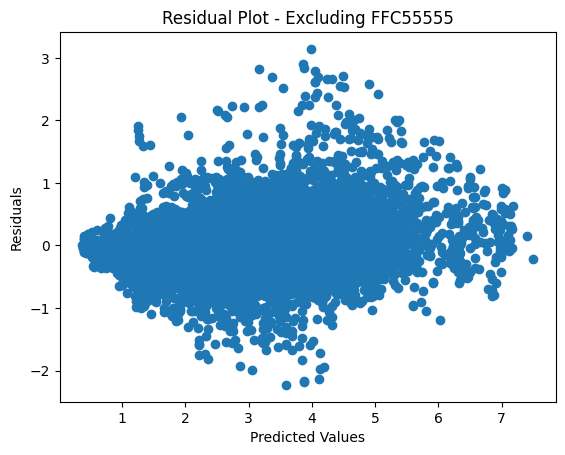

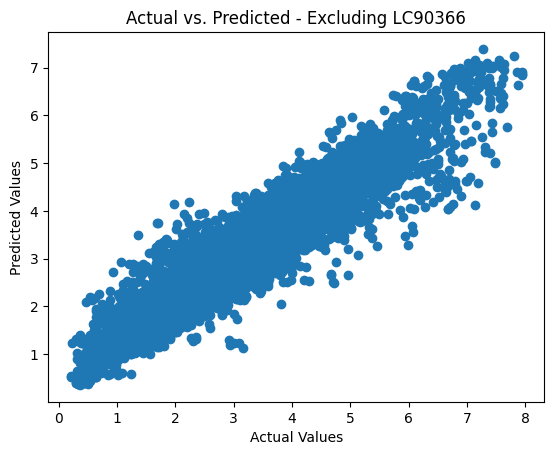

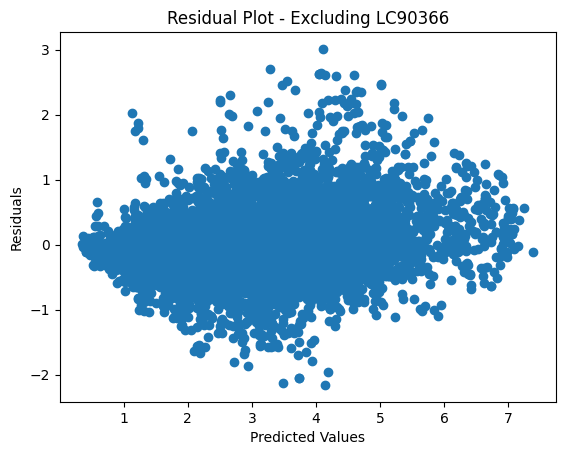

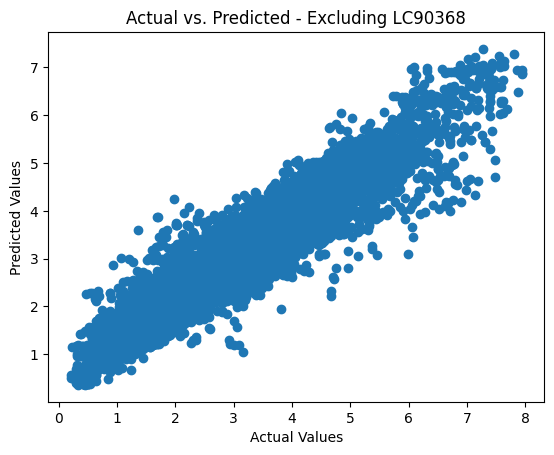

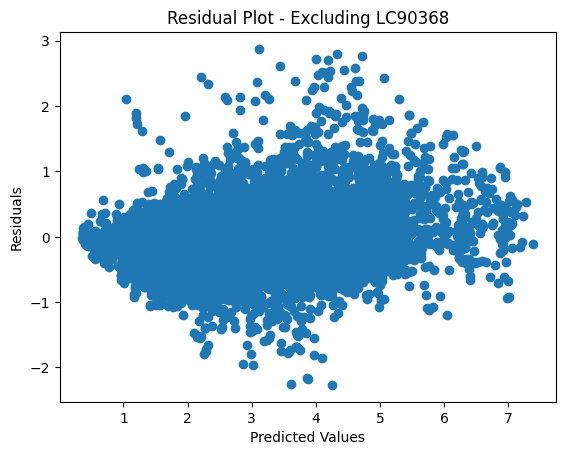

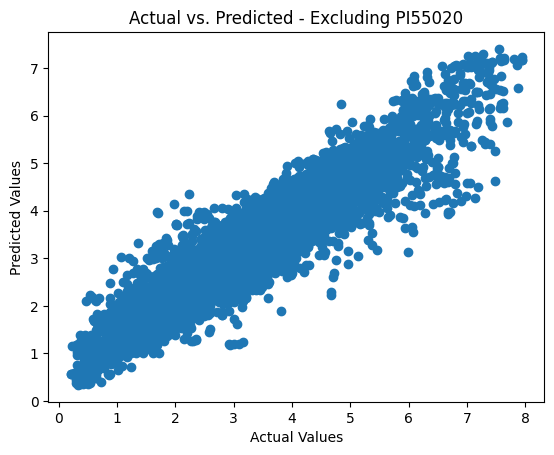

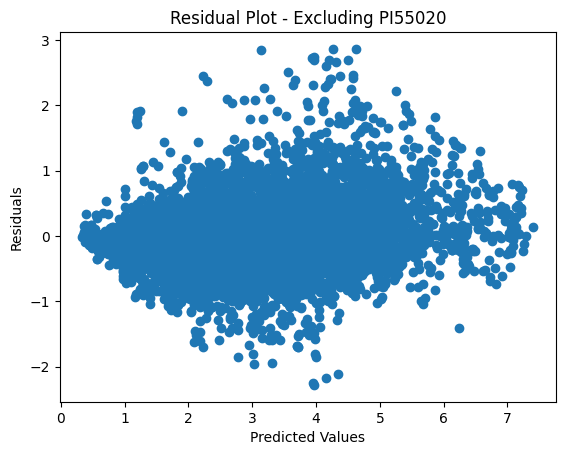

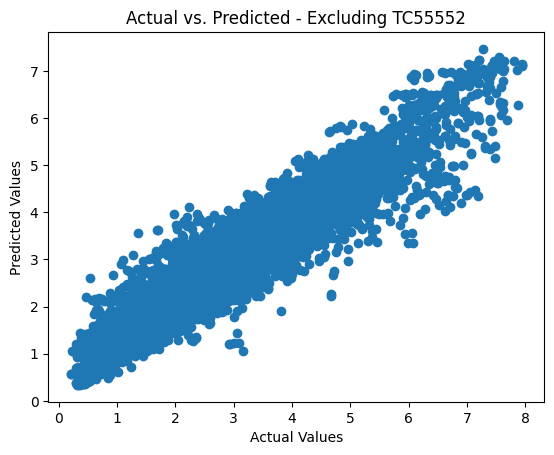

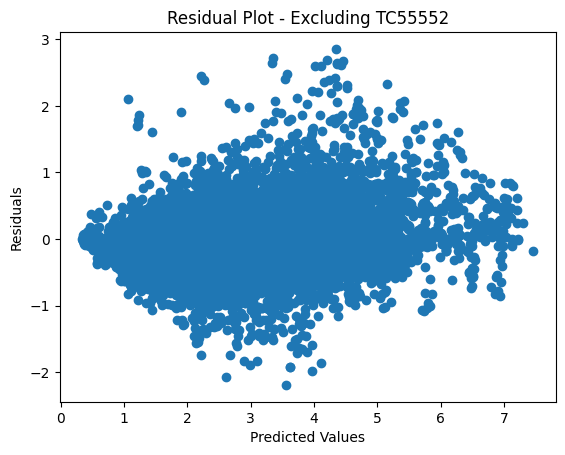

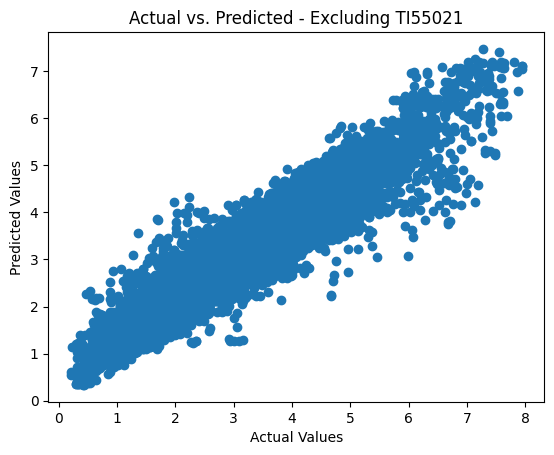

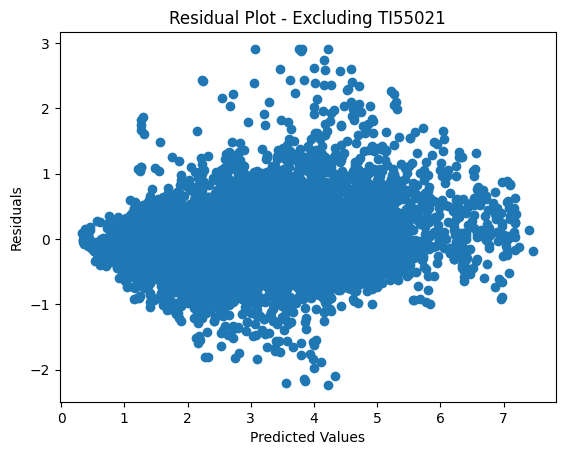

Feature Excluded: 425_pct_Al
MSE Train: 0.21213296051273534
RMSE Train: 0.4605789405875342
R2 Train: 0.9057860545633823
MSE Test: 0.25344528436237407
RMSE Test: 0.5034334954712232
R2 Test: 0.8875431497930878


Feature Excluded: M_Value
MSE Train: 0.20906950304764071
RMSE Train: 0.45724118695458826
R2 Train: 0.9071466183049444
MSE Test: 0.2530648967988069
RMSE Test: 0.5030555603497558
R2 Test: 0.8877119325240992


Feature Excluded: C4_pct_Eth
MSE Train: 0.21404092844077957
RMSE Train: 0.46264557540387174
R2 Train: 0.9049386747604837
MSE Test: 0.2576675977234879
RMSE Test: 0.507609690336471
R2 Test: 0.8856696564180897


Feature Excluded: C4_pct_H2O
MSE Train: 0.21066653536857607
RMSE Train: 0.45898424305042984
R2 Train: 0.9064373333565731
MSE Test: 0.2559986632499672
RMSE Test: 0.5059631046331019
R2 Test: 0.8864101835680268


Feature Excluded: HydWtr_pct_Ammonia
MSE Train: 0.2132497786880861
RMSE Train: 0.4617897559367099
R2 Train: 0.9052900456151227
MSE Test: 0.25676489984786377
RMSE Te

In [10]:

def feature_iteration_model(df, target_column_name, plot_results=False):
    original_features = df.drop(target_column_name, axis=1).columns
    model_performance = {}

    for feature in original_features:
        X = df.drop([target_column_name, feature], axis=1)
        y = df[target_column_name]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        xgb_model = xgb.XGBRegressor(
            objective ='reg:squarederror', 
            learning_rate=0.03,
            n_estimators=600,
            max_depth=7,
            subsample=0.9,
            colsample_bytree=0.8,
            gamma=2.0,
            alpha=0.2,
            reg_lambda=2,
            colsample_bylevel=0.8,
            colsample_bynode=0.7
        )
        xgb_model.fit(X_train, y_train)

        # Predict and evaluate on training data
        y_train_pred = xgb_model.predict(X_train)
        mse_train = mean_squared_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
        r2_train = r2_score(y_train, y_train_pred)

        # Predict and evaluate on test data
        y_pred = xgb_model.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(y_test, y_pred)

        # Store the metrics
        model_performance[feature] = {
            'MSE Train': mse_train,
            'RMSE Train': rmse_train,
            'R2 Train': r2_train,
            'MSE Test': mse_test,
            'RMSE Test': rmse_test,
            'R2 Test': r2_test
        }

        # Plotting (optional)
        if plot_results:
            plt.scatter(y_test, y_pred)
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.title(f'Actual vs. Predicted - Excluding {feature}')
            plt.show()

            residuals = y_test - y_pred
            plt.scatter(y_pred, residuals)
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.title(f'Residual Plot - Excluding {feature}')
            plt.show()

    return model_performance

# Assuming your data is in df_All and you want to predict 'Butanol'
performance_without_each_feature = feature_iteration_model(df_All, 'Decanol', plot_results=True)

# Print or analyze the performance dictionary
for feature, metrics in performance_without_each_feature.items():
    print(f"Feature Excluded: {feature}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")


In [11]:
# Assuming performance_without_each_feature is your model_performance dictionary
performance_df = pd.DataFrame.from_dict(performance_without_each_feature, orient='index')

print(performance_df) 

                    MSE Train  RMSE Train  R2 Train  MSE Test  RMSE Test  \
425_pct_Al           0.212133    0.460579  0.905786  0.253445   0.503433   
M_Value              0.209070    0.457241  0.907147  0.253065   0.503056   
C4_pct_Eth           0.214041    0.462646  0.904939  0.257668   0.507610   
C4_pct_H2O           0.210667    0.458984  0.906437  0.255999   0.505963   
HydWtr_pct_Ammonia   0.213250    0.461790  0.905290  0.256765   0.506720   
C4_pct_Hex           0.219490    0.468498  0.902519  0.263750   0.513566   
HydWtr_Na2O          0.209572    0.457790  0.906923  0.253778   0.503764   
DI55102              0.212797    0.461299  0.905491  0.256994   0.506945   
DI55152              0.214857    0.463526  0.904576  0.258423   0.508354   
FC55003              0.215539    0.464262  0.904273  0.256650   0.506606   
FC55009              0.210129    0.458398  0.906676  0.253838   0.503823   
FC55552              0.213780    0.462363  0.905055  0.257245   0.507193   
FC55569     

In [12]:
performance_df.to_csv('feature_test.csv', index=True)